# Assignment Part B Task 2 Data Visualisation

Student Name: Kuah Jia Chen <br>
Student ID: 32286988

## 1. Streaming data visualization

Import necessary libraries

In [1]:
# import statements
from time import sleep
from kafka import KafkaConsumer
import datetime as dt
import matplotlib.pyplot as plt
from json import *
import folium

# this line is needed for the inline display of graphs in Jupyter Notebook
%matplotlib notebook

Set a global variable to store topic name.

In [2]:
topic = 'AssignmentPartB'

Label interesting points (i.e., max)

In [3]:
def annotate_max(x, y, ax = None):
    ymax = max(y)
    xpos = y.index(ymax)
    xmax = x[xpos]
    text = 'Max: Time={}, Value={}'.format(xmax, ymax)
    if not ax:
        ax=plt.gca()
    ax.annotate(text, xy=(xmax, ymax), xytext=(xmax, ymax+5), arrowprops=dict(facecolor='red', shrink=0.05),)

Label interesting points (i.e., min)

In [4]:
def annotate_min(x, y, ax = None):
    ymin = min(y)
    xpos = y.index(ymin)
    xmin = x[xpos]
    text = 'Min: Time={}, Value={}'.format(xmin, ymin)
    if not ax:
        ax=plt.gca()
    ax.annotate(text, xy=(xmin, ymin), xytext=(xmin, ymin+5), arrowprops=dict(facecolor='orange', shrink=0.05),)

Connect to the kafka consumer by providing the topic name

In [5]:
def connect_kafka_consumer():
    _consumer = None
    try:
         _consumer = KafkaConsumer(topic,
                                   consumer_timeout_ms=10000, # stop iteration if no message after 10 sec
                                   auto_offset_reset='earliest', # comment this if you don't want to consume earliest available message
                                   bootstrap_servers=['localhost:9092'],
                                   api_version=(0, 10))
    except Exception as ex:
        print('Exception while connecting Kafka')
        print(str(ex))
    finally:
        return _consumer

Plot the initial plot

In [6]:
def init_plots():
    try:
        width = 9.5
        height = 6
        fig = plt.figure(figsize=(width,height)) # create new figure
        ax = fig.add_subplot(111) # adding the subplot axes to the given grid position
        # giving figure a title
        fig.suptitle('Real-time climate data air temperature data visualization with interesting points') 
        ax.set_xlabel('Time')
        ax.set_ylabel('Air Temperature')
        ax.set_ylim(0,40) 
        ax.set_yticks([0,20,40])
        fig.show() # displaying the figure
        fig.canvas.draw() # drawing on the canvas
        return fig, ax
    except Exception as ex:
        print(str(ex))

In [7]:
def consume_messages(consumer, fig, ax):
    try:
        
        # container for x and y values
        x, y = [], []
        
        for message in consumer:
            key = str(message.key.decode('utf-8'))
            data = str(message.value.decode('utf-8')) 
            data = loads(data) # need to convert it to dictionary
            
            if key == 'climate':
                
                x.append(dt.datetime.now().strftime("%X")) 
                y.append(int(data['air_temperature_celcius']))

                # we start plotting even we only have 1 data point
                if len(y) > 1:
                    ax.clear()
                    ax.plot(x, y)
                    ax.set_xlabel('Time')
                    ax.set_ylabel('Air Temperature')
                    ax.set_ylim(0,40) 
                    ax.set_yticks([0,20,40])
                    annotate_max(x,y)
                    annotate_min(x,y)
                    fig.canvas.draw()
                    if len(y) > 10:  # only allow 10 data points at most
                        x.pop(0)     # removing the item in the first position
                        y.pop(0)
        plt.close('all')
    except Exception as ex:
        print(str(ex))

<IPython.core.display.Javascript object>


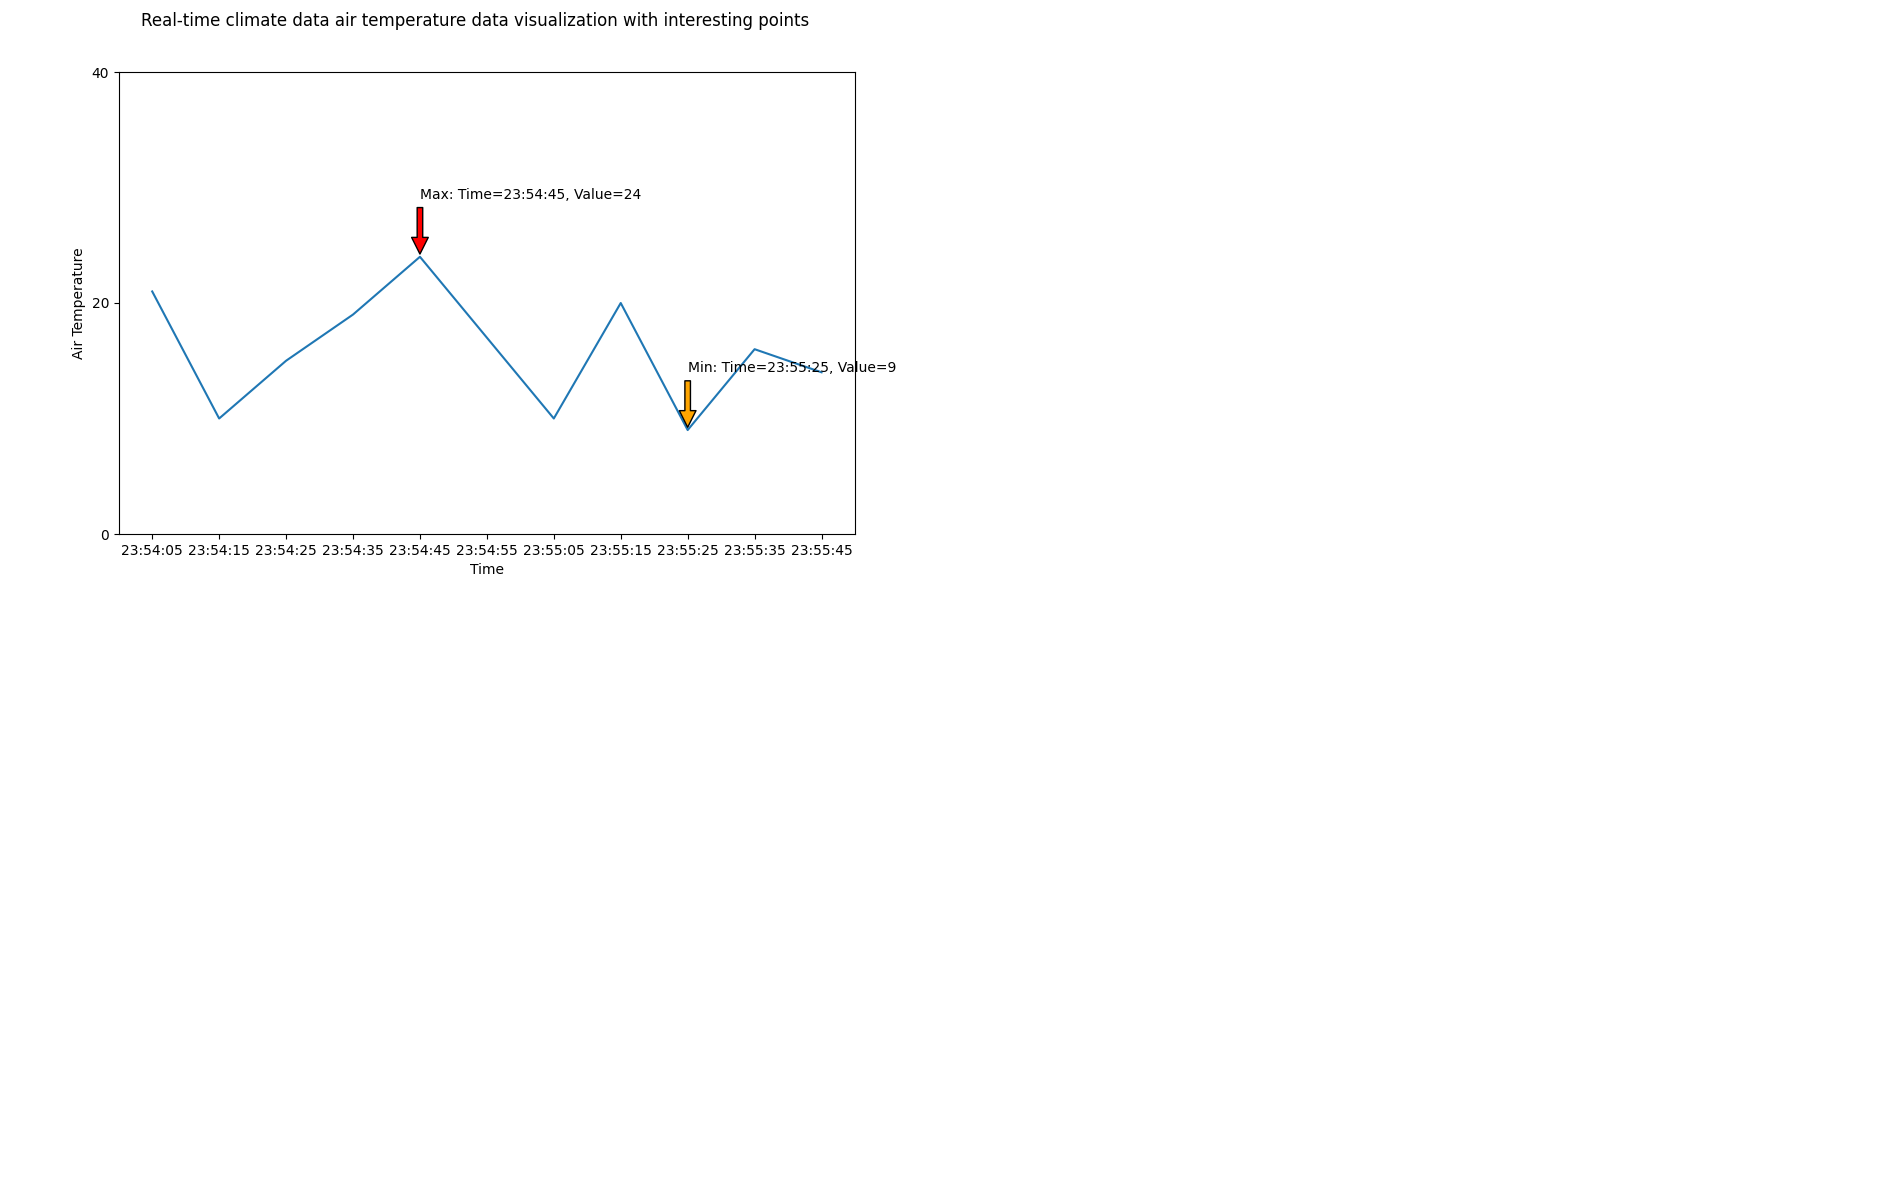

KeyboardInterrupt: 

In [8]:
if __name__ == '__main__':
    
    consumer = connect_kafka_consumer()
    fig, ax = init_plots()
    consume_messages(consumer, fig, ax)

## 2. Static data visualization

#### a. Plot a bar chart to visualize the total number of fire records based on each hour.

Make a connection to mongodb

In [9]:
from pymongo import MongoClient
from pprint import pprint

# Create a MongoClient/Mongodb connection 
client = MongoClient()

# We will use the database: fit3182_assignment_db
db = client.fit3182_assignment_db

# The collection name is climate and hotspot
assignment_partB = db.assignment_partB

Get the number of fire for each hour. The index of no_of_records_per_hour represents the hour and the value on that particular index is the number of fires for that hour. Hence, there are 24 elements in the no_of_records_per_hour list.

In [10]:
# Prepare the total number of fire records for each hour using data from MongoDB
cursor = assignment_partB.aggregate([
    {"$unwind":"$hotspots"}, 
    {"$project":{ "hourSubString": { "$substr": [ "$hotspots.datetime", 11, 2 ] }}}
   ])

no_of_records_per_hour = [0]*24
for document in cursor:  
    no_of_records_per_hour[int(document['hourSubString'])] += 1

print(no_of_records_per_hour)

[0, 0, 0, 0, 11, 0, 0, 0, 0, 11, 0, 0, 0, 0, 7, 0, 0, 0, 8, 0, 0, 0, 0, 12]


Visualise the data in bar chart 

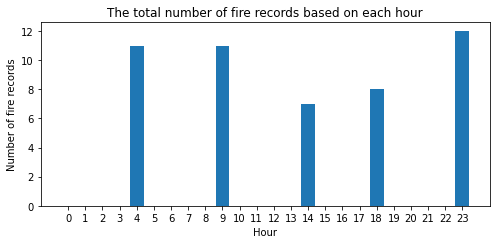

In [11]:
from matplotlib import pyplot as plt
%matplotlib inline

# Set the figure size
plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True

# Plot bar chart with data points
hour = []
for i in range(24):
    hour.append(i)
plt.bar(hour, no_of_records_per_hour)

# Display the plot
plt.xticks(hour)
plt.xlabel("Hour")
plt.ylabel("Number of fire records")
plt.title("The total number of fire records based on each hour")
plt.show()

Explanation on the bar chart:

As stated in the documentation of Producers 2 and 3, we only have 5 unique times generated by them. Hence, in other words, there would be only five particular hours has the fire event, hence the bar chart would at most shows fire bars. (i.e., 1 to 5 bars where depends on the data generated)

#### b. In a map visualize fire locations as markers. Use a ‘blue’ marker if the cause of the fire was ‘natural’. Otherwise, use a ‘red’ marker. Display detailed information such as air temperature, surface temperature, relative humidity,and confidence with the marker tooltip

In [12]:
# Prepare the fire data using data from MongoDB
fireEvents = []

cursor = assignment_partB.aggregate([
    {"$unwind":"$hotspots"}, 
    # only output the necessary details
    {"$project":{"hotspots.latitude":1,"hotspots.longitude":1, "air_temperature_celcius":1, \
                 "hotspots.surface_temperature_celcius":1, "relative_humidity":1, "hotspots.confidence":1, \
                 "hotspots.cause_of_fire":1, "_id":0}}
   ])

# Looping through all the hotspot data and check if the cause of fire was natural or other. 
# After that, append the information to fireEvents list. The last element for each sublist stores the colour of the marker
for row in cursor:

    if row['hotspots']['cause_of_fire'] == 'other':
        fireEvents.append([row['hotspots']['latitude'],row['hotspots']['longitude'],row['air_temperature_celcius'],\
                               row['hotspots']['surface_temperature_celcius'], row['relative_humidity'], \
                               row['hotspots']['confidence'],'red']) # red marker for other
    else: 
        fireEvents.append([row['hotspots']['latitude'],row['hotspots']['longitude'],row['air_temperature_celcius'],\
                               row['hotspots']['surface_temperature_celcius'], row['relative_humidity'], \
                               row['hotspots']['confidence'],'blue']) # blue marker for natural

In [13]:
# find the average latitude and longitude and use it as the center coordinates
sum_latitude = 0
sum_longitude = 0
for row in fireEvents:
    sum_latitude += row[0]
    sum_longitude += row[1]
average_latitude = sum_latitude/len(fireEvents)
average_longitude = sum_longitude/len(fireEvents)

Output the center coordinates

In [15]:
print(average_latitude,average_longitude)

-37.253569387755114 143.75794897959184


Initialize the map using the center coordinates

In [16]:
fomap = folium.Map(location=[average_latitude, average_longitude], zoom_start=8)

Plot a marker for each fire event. Ensure that the necessary information are provided once the user clicked on the marker.

In [17]:
for loc in fireEvents:
    folium.Marker(location=(loc[0],loc[1]), 
                  popup="Latitude: " + str(round(loc[0],2)) + " <br>Longitude: " + str(round(loc[1],2)) + 
                  " <br>Air Temperature: " + str(loc[2]) + " <br>Surface Temperature: " + str(loc[3]) 
                  + " <br>Relative Humidity: " + str(loc[4]) + " <br>Confidence: " + str(loc[5]) , 
                  icon=folium.Icon(color=loc[6]),).add_to(fomap)

Show the map.

In [18]:
fomap